## <center>COMP20008 - 2018 - SM2 - Project Phase 2</center>
<center>Release Date: 11:59am Monday, $3^{rd}$ September 2018</center>
<center>Due Date: 11:59am Friday, $21^{st}$ September 2018</center>
<center>Submission is via the LMS</center>
<span style="color:red">Please, make sure you get a submission confirmation email once you submit your assignment. Otherwise, it will be considered as a late submission.</span> 


#### Phase 2: Python Data Wrangling (15 marks, worth 15% of subject grade) 

For banks, risk management and default detection has always been a crucial part in issuing credit cards (defaulting on a credit card means that a person was unable to pay a credit card bill). Defaults on credit cards can result in a great financial loss. In this phase, you will practice your Python wrangling skills, specifically correlation, classification and clustering parts with a modified version of an available default credit cards dataset at the UCI Machine Learning Repository. The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

In this phase, you will be working with the "UCI_Credit_Card_Modified.csv" dataset. It has 200 records for credit card users, each is described by 25 variables. 

Libraries to use are Pandas, Matplotlib, NumPy, SciPy, seaborn and sklearn. You will need to write Python 3 code (Jupyter notebook) and work with the topics discussed in workshops weeks 6-8. If you are using other packages, you must provide an explanation in your code about why it is necessary.

#### Dataset Content
There are 25 variables: (1 ID, 1 label, 23 features/attributes)
       
- ID: ID of each client
- limit_bal: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- is_male: **Binary** : Gender (1=male, 0=female)
- education: **Categorical** : (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- is_married: **Binary** : Marital status (1=married, 0= not married, i.e. single or others)
- age: Age in years
- pay_1: **Numerical** : Repayment status in September, 2005 (0=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- pay_2: **Numerical** : Repayment status in August, 2005 (scale same as above)
- pay_3: **Numerical** : Repayment status in July, 2005 (scale same as above)
- pay_4: **Numerical** : Repayment status in June, 2005 (scale same as above)
- pay_5: **Numerical** : Repayment status in May, 2005 (scale same as above)
- pay_6: **Numerical** : Repayment status in April, 2005 (scale same as above)
- bill_amt1: **Numerical** : Amount of bill statement in September, 2005 (NT dollar)
- bill_amt2: **Numerical** : Amount of bill statement in August, 2005 (NT dollar)
- bill_amt3: **Numerical** : Amount of bill statement in July, 2005 (NT dollar)
- bill_amt4: **Numerical** : Amount of bill statement in June, 2005 (NT dollar)
- bill_amt5: **Numerical** : Amount of bill statement in May, 2005 (NT dollar)
- bill_amt6: **Numerical** : Amount of bill statement in April, 2005 (NT dollar)
- pay_amt1: **Numerical** : Amount of previous payment in September, 2005 (NT dollar)
- pay_amt2: **Numerical** : Amount of previous payment in August, 2005 (NT dollar)
- pay_amt3: **Numerical** : Amount of previous payment in July, 2005 (NT dollar)
- pay_amt4: **Numerical** : Amount of previous payment in June, 2005 (NT dollar)
- pay_amt5: **Numerical** : Amount of previous payment in May, 2005 (NT dollar)
- pay_amt6: **Numerical** : Amount of previous payment in April, 2005 (NT dollar)
- label: **Binary** :Default payment (1=yes, 0=no)

### Import Required Python Libraries and Load the Data 

Please write here all the Python libraries you will be using! Also load the dataset (.csv) in a dataframe object.

In [1]:
#import (from specs)...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier

#for using seaborn in the entirity
from matplotlib.style import use


### Helper Functions 

This section includes few functions discussed in workshops week 6 and 7, and will be used in this assignment.

In [2]:
def VAT(R):
          
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

def my_entropy(probs):
    return -probs.dot(np.log2(probs))
def mutual_info(X,Y):
    
    df = pd.DataFrame.from_dict({'X' : X,  'Y' :Y})
    Hx = my_entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = my_entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    
    counts = df.groupby(["X","Y"]).size()
    probs = counts/ counts.values.sum()
    H_xy = my_entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy)  
    return NMI

In [3]:
default_credit_card_df =  pd.read_csv("UCI_Credit_Card_Modified.csv", index_col="ID")

### 1 Data Preparation and Dimension Reduction <span style="color:red">**(5 Marks)**</span> 

#### 1.1 Categorical Features:

In this assignment, you will use the dataset to perform clustering and classification methods. In this regard, using categorical features might lead to inaccurate evaluation results. Therefore, categorical features should be converted to numerical first. The provided default credit card dataset contains one categorical attribute "education" (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown). Write code to replace the "education" column with another three numerical columns of type integer, with the names "graduate_school", "university" and "high_school". The three numerical columns will have the value 0 or 1, where each categorical value will be converted to a binary vector as follow: **(1 Mark)** 
    
\begin{array} {llll}
\\
\text{old value} & \text{new values}&&\\
\text{education} & \text{graduate_school} & \text{university} & \text{high_school}\\
1 &1&0&0 \\
2 &0&1&0 \\
3 &0&0&1 \\
4 &0&0&0 \\
5 &0&0&0 \\
6 &0&0&0 \\
\end{array}

The resulted dataframe should include 26 columns in the following order:

<font size=1> 
\begin{array} {|c|c|c|c|c|c|c|c|c|}
\hline
limit\_bal & is\_male & grad\_school & university & high\_school &  is\_married & age & pay\_1 & pay\_2 \\
\hline
pay\_3 & pay\_4 & pay\_5 & pay\_6 & bill\_amt1 & bill\_amt2 & bill\_amt3 & bill\_amt4 & bill\_amt5 \\
\hline
bill\_amt6 & pay\_amt1 & pay\_amt2 & pay\_amt3 & pay\_amt4 & pay\_amt5 & pay\_amt6 & label & \\
\hline
\end{array}

</font>

Note that the "ID" column should be the dataframe index. The output of this step should print the first two rows of the dataframe using df.head(2).




In [4]:
### answer Q1.1

FILTERS = ["limit_bal", "is_male", "grad_school", "university","high_school", "is_married", "age","pay_1","pay_2",
           "pay_3","pay_4", "pay_5", "pay_6", "bill_amt1", "bill_amt2", "bill_amt3","bill_amt4", "bill_amt5",
           "bill_amt6","pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4","pay_amt5","pay_amt6","label"]
#make 3 new columns
university = pd.Series(default_credit_card_df["education"].replace({2: 1, 1:0, 3: 0,4: 0,5: 0,6: 0}))
high_school = pd.Series(default_credit_card_df["education"].replace({2: 0, 1:0, 3: 1,4: 0,5: 0,6: 0}))

grad_school = pd.Series(default_credit_card_df["education"].replace({2: 0, 1:1, 3: 0,4: 0,5: 0,6: 0}))

#make a dataframe and add the 3 columns
new_df = pd.DataFrame(default_credit_card_df)
new_df["grad_school"] = pd.Series(grad_school)
new_df["university"] = pd.Series(university)
new_df["high_school"] = pd.Series(high_school)

#reordering the columns
new_df = pd.DataFrame(new_df.loc[:,FILTERS])

display(new_df.head(2))




,limit_bal,is_male,grad_school,university,high_school,is_married,age,pay_1,pay_2,pay_3,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,label
ID,,,,,,,,,,,,,,,,,,,,,
1657,150000,0,1,0,0,0,29,0,0,2,...,64468,66488,58131,7500,0,4000,4000,4000,3500,1
8509,50000,1,0,1,0,0,24,1,0,0,...,0,0,0,0,0,0,0,0,0,1


#### 1.2 Feature Scaling:

The second step in the data preparation is the feature scaling/transformation. You will use **sklearn.preprocessing.StandardScaler()** function to normalise each attribute separately, to have 0 mean and unit variance. To do so, implement the following steps: **(1 Mark)**

- Create a features matrix "X" which contains all columns in your dataframe except the "label" column.
- Create a vector "y" which contains the values in the column "label" in your dataframe.
- Use the StandardScaler() function to normalise the features matrix "X". Store the transformed features in "X_scaled" matrix. 

The output of this question should print shape, min, max, average and standard deviation of "X_scaled" matrix in the following format:
    
    *** 
    Q1.2: X_scaled matrix details
    Shape: # 
    Min: #
    Max: # 
    Average: #
    Standard Deviation: # 
    ***
    
where # is the calculated values <span style="color:blue">rounded to 4 decimal places</span>.

In [5]:
### answer Q1.2

#make X and normalise it. 
FILTERS = [i for i in FILTERS if i != "label"]
X = new_df.loc[:,FILTERS].values
X_scaled = StandardScaler().fit_transform(X)

#make y. 
y = new_df.iloc[:,-1]

print("***") 
print("Q1.2: X_scaled matrix details")
print("Shape: {}".format(X_scaled.shape))
print("Min: {0:0.4f} ".format(X_scaled.min()))
print("Max: {0:0.4f}".format(X_scaled.max())) 
print("Average: {0:0.4f}".format(X_scaled.mean()))
print("Standard Deviation: {0:0.4f}".format(X_scaled.std())) 
print("***") 



***
Q1.2: X_scaled matrix details
Shape: (200, 25)
Min: -1.4926 
Max: 13.0260
Average: -0.0000
Standard Deviation: 1.0000
***


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### 1.3 Dimension Reduction: PCA

It is hard to visualise default clients versus non-default clients since each client has 25 attributes. Write code to reduce number of dimensions for "X" matrix to two dimensions by using PCA. Store the result in "X_reduced" matrix. Then, use "X_reduced" matrix to display a scatter plot. X-axis should contain the first principal component and y-axis should contain the second principal component. Default clients should be colored with red, while other non-default clients should be colored with blue. **(3 Marks)**

Then, implement the same steps with "X_scaled" data matrix instead of "X" matrix. Now, you should have two plots. Assign the titles "Dimension reduction without feature scaling" and "Dimension reduction with feature scaling" for the two plots respectively. The final output of this question should be one figure with the two required plots. 


- Based on the visualised plots, which features data matrix is better for PCA, "X_scaled" or "X"? Why?
- Do you think using PCA is a good idea for visualising the default credit card clients? Yes/No, why?

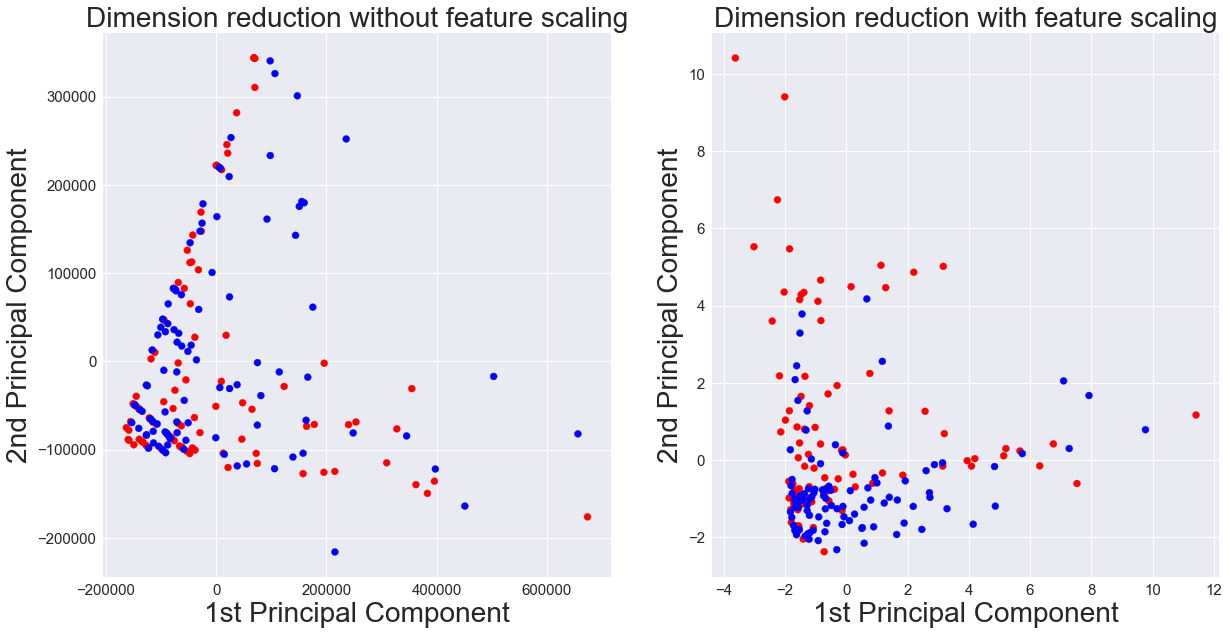

In [6]:
### answer Q1.3

#we want just the first two Principal Components
sklearn_pca = PCA(n_components=2)   

#make X_reduced
X_reduced = sklearn_pca.fit_transform(X)
tmp_df = pd.DataFrame(X_reduced)


#using seaborn for the entire Phase 2
use('seaborn')


#coloring
sns.set(font_scale=1.25)
red_blue = y.replace([1,0],['r','b'])
fig = plt.figure(figsize = (20,10))

#draw without scaling....
plt.subplot(1,2,1)
plt.xlabel('1st Principal Component', fontsize=28)
plt.ylabel('2nd Principal Component', fontsize=28)
plt.title("Dimension reduction without feature scaling",fontsize=28 )
plt.scatter(tmp_df.iloc[:,0],tmp_df.iloc[:,1], color = red_blue)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)


#use X_scaled
X_standard_reduced = sklearn_pca.fit_transform(X_scaled)
tmp_df = pd.DataFrame(X_standard_reduced)

#draw with scaling....
plt.subplot(1,2,2)
plt.xlabel('1st Principal Component', fontsize=28)
plt.ylabel('2nd Principal Component', fontsize=28)
plt.title("Dimension reduction with feature scaling",fontsize=28 )
plt.scatter(tmp_df.iloc[:,0],tmp_df.iloc[:,1], color = red_blue)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.show() 







### 2 Clustering and Clustering Visualisation <span style="color:red">**(5 Marks)**</span>

In this section you will perform some of the clustering and clustering visualisation techniques. 

#### 2.1 Hierarchical Clustering: 

Write code to plot the dendrogram using "X_scaled" matrix for each of the  linkage methods: **COMPLETE** and **SINGLE**. You should also use Euclidean distance to calculate the dissimilarity matrix. **(2 Marks)**

The output of this question should be one figure with two dendrogram sub-plots. First sub-plot should have the title "Agglomerative clustering with complete linkage method", while the second sub-plot should have the title "Agglomerative clustering with single linkage method".

Following this, you need to look at the y-axis range for the generated dendrograms and justify the different y-axis range/scale for each dendrogram.

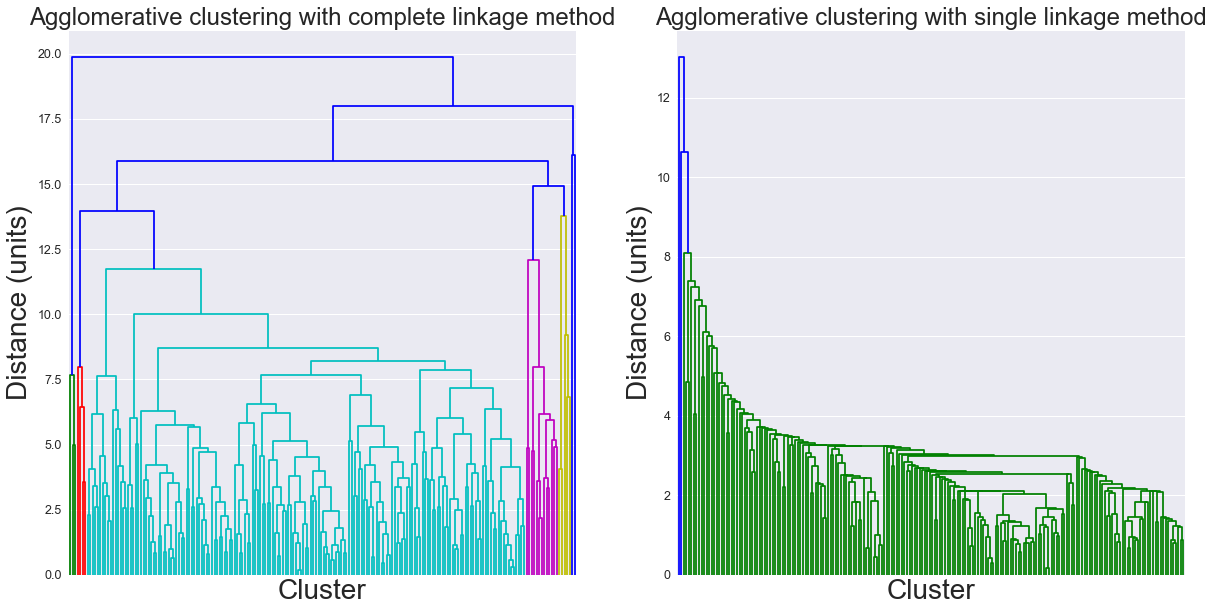

In [7]:
### answer Q2.1


d = pdist(X_scaled, 'euclidean')

fig = plt.figure(figsize=(20, 10))

#gives the complete dendogram
plt.subplot(1,2,1)
complete_dendogram = linkage(d, 'complete') 
dendrogram(complete_dendogram,  no_labels = True)
plt.title("Agglomerative clustering with complete linkage method", fontsize = 24)
plt.xlabel('Cluster', fontsize=28)
plt.ylabel('Distance (units)', fontsize=28)


#gives the minimum dendogram
plt.subplot(1,2,2)
single_dendogram =  linkage(d, 'single') 
dendrogram(single_dendogram,no_labels = True)
plt.title("Agglomerative clustering with single linkage method", fontsize = 24)
plt.xlabel('Cluster', fontsize=28)
plt.ylabel('Distance (units)', fontsize=28)
plt.show()



#### 2.2 Clustering Visualisation: 

In this question, you will plot the heatmap for both dissimilarity matrix and ordered dissimilarity matrix. First, calculate "Euclidean distance" dissimilarity matrix for the "X_scaled" data matrix. Next, use the VAT() function discussed in workshop-week6, in order to get the ordered dissimilarity matrix for the "X_scaled" data matrix. Finally, plot the heatmap for "Euclidean" dissimilarity matrix and the ordered one (i.e. VAT heatmap). **(3 Marks)**

The final output of this question should be one figure with two sub-plots. Use appropriate titles and xy-labels for each sub-plot. 

Is there any relation between the ordered dissimilarity matrix (VAT heatmap) and the complete linkage dendrogram plots? If yes, describe one relation between both plots.

Knowing that the dataset contains two classes (default and non-default clients), does VAT heatmap give an accurate number of clusters? Yes|No, why?

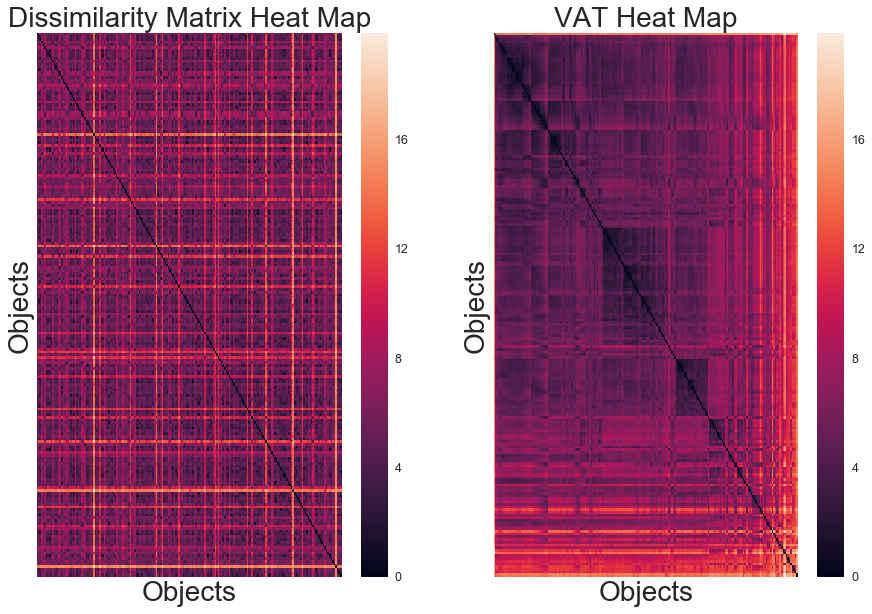

In [8]:
### answer Q2.2
#dissimilarity matrix
d = squareform(pdist(X_scaled, 'euclidean'))

#ordered dissimilarity matrix
RV, C, I = VAT(d)

#plot dissimilarity matrix heat map
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(d,xticklabels=False,yticklabels=False, ax = axes[0])
axes[0].set_title(label = "Dissimilarity Matrix Heat Map", size = 28)
axes[0].set_xlabel('Objects', size = 28)
axes[0].set_ylabel('Objects', size = 28)

#plot ordered dissimilarity <VAT> matrix heat map
sns.heatmap(RV,xticklabels=False,yticklabels=False, ax = axes[1])
axes[1].set_title(label = "VAT Heat Map", size = 28)
axes[1].set_xlabel('Objects', size = 28)
axes[1].set_ylabel('Objects', size = 28)

plt.show()


### 3 Correlation and Mutual Information <span style="color:red">**(7 Marks)**</span>

In this section you will investigate the correlation and mutual information between credit card dataset attributes and the class label. 

#### 3.1 Pearson Correlation:
Write code to calculate correlation matrix of size 25 x 25 (25 is the number of attributes) from "X_scaled" data matrix. The calculated symmetric matrix should contain the correlation between every pair of attributes. For example, a value in row i and column j should contain the Pearson correlation $r_{ij}$ between two attributes i and j. Then, plot the heatmap for the calculated correlation matrix. **(3 Marks)**

The final output for this question should look like the below heatmap plot. Note that the values in this plot are randomly generated and you should get different colors/values for your visualised heatmap. 

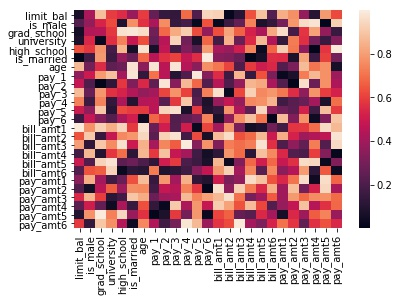

Based on your visualised heatmap and the calculated correlation values between every pair attributes, report three different/interesting findings/explanations! For example you might look at the highest and/or lowest r values, and justify/explain whether you expected such high or low correlation between those attributes or not.

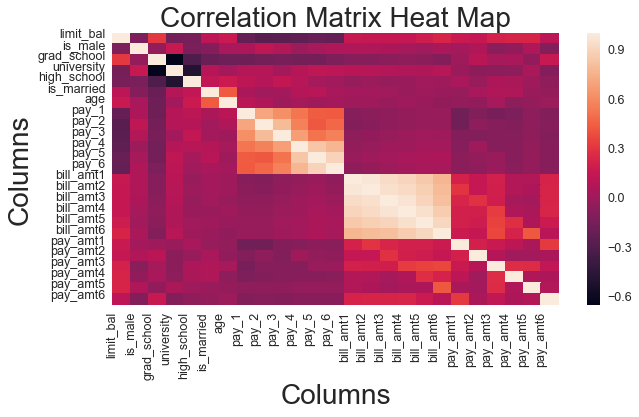

In [9]:
### answer Q3.1

tmp_df = pd.DataFrame(X_scaled)

#plot correlation heatmap
plt.figure(figsize = (10,5))
sns.heatmap(tmp_df.corr(),xticklabels=False,yticklabels=False)

#set the labels
plt.title( "Correlation Matrix Heat Map", size = 28)
plt.xlabel('Columns', size = 28)
plt.ylabel('Columns', size = 28)
plt.xticks([i for i in range(len(FILTERS))],FILTERS, rotation = 90)
plt.yticks([i for i in range(len(FILTERS))],FILTERS)


plt.show()

#### 3.2 Mutual Information:
In this question, you will use the provided mutual_info() and my_entropy() functions discussed in workshop-week7 to calculate the mutual information between different attributes and the class label. 
Since discretisation is an important preprocessing for MI calculations, you will be using the "X" data matrix (i.e. without scaling) in this question. By looking at "X" data matrix, attributes can be split into 11 discrete and 14 numerical. **(4 Marks)**

**Discrete columns** are ['is_male', 'grad_school', 'university', 'high_school', 'is_married', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] and <br />
**Numerical columns** are ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

First, you need to discretize each of the numerical attributes by using 4-bin equal-width technique. The output for this step should have the following format:

################# limit_bal ################# <br />
bin# 1: range [a,b) <br />
bin# 2: range [a,b) <br />
bin# 3: range [a,b) <br />
bin# 4: range [a,b) <br />
. <br />
. <br />
. <br />
. <br />
################# pay_amt6 ################# <br />
bin# 1: range [a,b) <br />
bin# 2: range [a,b) <br />
bin# 3: range [a,b) <br />
bin# 4: range [a,b)

<span style="color:blue">where a and b are the calculated range for each bin.</span> 

Next, calculate the normalised mutual information (NMI) between each of the columns (i.e. 25 in total) and the class label "y". Then, display a bar plot for the calculated NMI values. The plot should contains 25 bars, each bar represent the NMI value between attribute i and label y. The format of the bar plot should be similar to the below plot. Note that the NMI values in this plot are randomly generated and you will get different bars/values for your bar plot. 

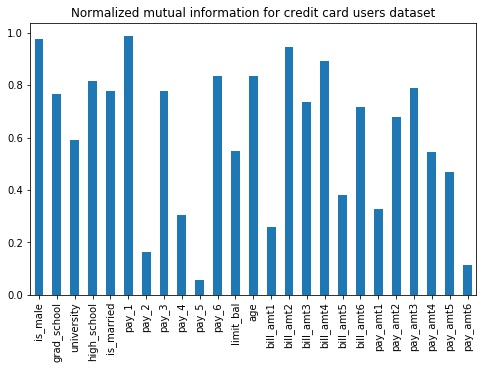


################# limit_bal #################
bin# 1: range [10000.0,135000.0)
bin# 2: range [135000.0,260000.0)
bin# 3: range [260000.0,385000.0)
bin# 4: range [385000.0,510500.0)
################# age #################
bin# 1: range [22.0,34.0)
bin# 2: range [34.0,46.0)
bin# 3: range [46.0,58.0)
bin# 4: range [58.0,70.048)
################# bill_amt1 #################
bin# 1: range [-16.0,99762.75)
bin# 2: range [99762.75,199541.5)
bin# 3: range [199541.5,299320.25)
bin# 4: range [299320.25,399498.115)
################# bill_amt2 #################
bin# 1: range [-802.0,98731.5)
bin# 2: range [98731.5,198265.0)
bin# 3: range [198265.0,297798.5)
bin# 4: range [297798.5,397730.134)
################# bill_amt3 #################
bin# 1: range [-1282.0,93117.75)
bin# 2: range [93117.75,187517.5)
bin# 3: range [187517.5,281917.25)
bin# 4: range [281917.25,376694.599)
################# bill_amt4 #################
bin# 1: range [-1037.0,80641.0)
bin# 2: range [80641.0,162319.0)
bin# 3: range 

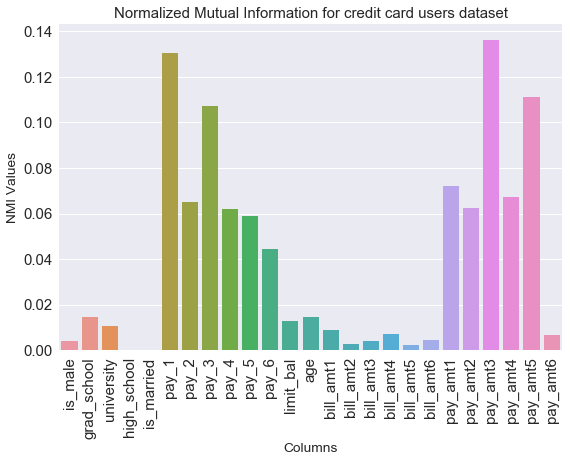

In [10]:
### answer Q3.2
DISCRETE = ['is_male', 'grad_school', 'university', 'high_school', 'is_married', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
NUMERICAL =  ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 
               'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    
def discretize(df):
    """discretize each numerical column  into 4 equal width bins"""
    for i in NUMERICAL:
        bins = pd.cut(df[i], 4, retbins=True, right=False, include_lowest = True)[-1]
        print('################# {} #################'.format(i))
        print('bin# 1: range [{},{})'.format(bins[0],bins[1]))
        print('bin# 2: range [{},{})'.format(bins[1],bins[2]))
        print('bin# 3: range [{},{})'.format(bins[2],bins[3]))
        print('bin# 4: range [{},{})'.format(bins[3],bins[4]))
        df[i] = pd.cut(df[i],4,right=False, include_lowest = True, labels = False)
        

#discretize each numerical column
tmp_df = pd.DataFrame(new_df.loc[:,FILTERS])
bar_df = pd.DataFrame({}, index = ["NMI Values"])
discretize(tmp_df)

tmp_df = tmp_df.loc[:, DISCRETE + NUMERICAL]


#calculate NMI values
for i in tmp_df.columns:
    bar_df[i] = mutual_info(tmp_df.loc[ :, i],y)
        
#transpose it for plotting..
bar_df = bar_df.transpose()


#plot...
plt.figure(figsize = (9,6))
plt.xticks(rotation = 90)


plt.xlabel("Columns")
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.title("Normalized Mutual Information for credit card users dataset")

sns.barplot(bar_df.index, bar_df.iloc[:,0])
plt.show()



### 4 Classification <span style="color:red">**(7 Marks)**</span>

In this section you will create a model to predict credit card default. This will enable you to answer the question: who is going to default into the credit card payments next month. Functions used in this section are covered in workshop-week8 materials.

#### 4.1 Train-Test Split:
To evaluate the performance of any model/classifier, you should test it on unseen set of instances. Therefore, as a preparation for the model training, you will split your features matrix "X" into training and testing sets. Specifically, you will use train_test_split() function from sklearn.model_selection to randomly select 80% of the instances to be training and the rest to be testing. **(1 Mark)**

The output of the function should contain two matrices: **X_train** and **X_test**, and two vectors/columns: **y_train** and **y_test**. 
- X_train contains features of training instances (i.e. 80%) and y_train contains labels for the training instances. 
- X_test contains features of test instances (i.e. 20%) and y_test contains labels for test instances. 

The output of this question should print shape of X_train, X_test, y_train and y_test in the following format:
    
    *** 
    Q4.1: Train Test Split Results
    X_train matrix: #
    y_train labels: # 
    X_test matrix: #
    y_test labels: #
    ***

where # is the calculated shape values. 

In [11]:
### answer Q4.1
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state =42)

print("***")
print("Q4.1: Train Test Split Results")
print("X_train matrix: {}".format( X_train.shape))
print("y_train labels: {}".format( y_train.shape))
print("X_test matrix: {}".format( X_test.shape))
print("y_test matrix:{}".format( y_test.shape))
print("***")



***
Q4.1: Train Test Split Results
X_train matrix: (160, 25)
y_train labels: (160,)
X_test matrix: (40, 25)
y_test matrix:(40,)
***


#### 4.2 Feature Scaling:
Another preprocessing step before training any classifier is normalising the data features. Because features with large scale might bias the trained classifier. Write code to transform each feature (i.e. column) in both training and testing sets, (i.e. X_train and X_test matrices), to have 0 mean and unit variance. Each transformed matrix should be stored with the same variable name, i.e. X_train and X_test. **(1 Mark)**

Is it a good idea to use the transformed matrix "X_scaled" as input for the split function and in this case, we don't have to scale/transform the resulted X_train and X_test, Yes/No? Why?


In [12]:
### answer Q4.2
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

"""
sanity checking, uncomment to see the average and standard deviation after normalised.  
print("X_train:")
print("Average: {0:0.4f}".format(X_train.mean()))
print("Standard Deviation: {0:0.4f}".format(X_train.std())) 

print("X_test:")
print("Average: {0:0.4f}".format(X_test.mean()))
print("Standard Deviation: {0:0.4f}".format(X_test.std())) 
"""


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


'\nsanity checking, uncomment to see the average and standard deviation after normalised.  \nprint("X_train:")\nprint("Average: {0:0.4f}".format(X_train.mean()))\nprint("Standard Deviation: {0:0.4f}".format(X_train.std())) \n\nprint("X_test:")\nprint("Average: {0:0.4f}".format(X_test.mean()))\nprint("Standard Deviation: {0:0.4f}".format(X_test.std())) \n'

#### 4.3 K-nearest Neighbor Classifier:
In this question, you will build a K-NN classifier by using the built-in functions from sklearn package. To do so, implement the following steps: **(3 Marks)** <br />
    
   - Create an instance from the model/estimator (i.e. KNeighborsClassifier) and set the K (number of neighbors) to 3.
   - Train/fit the model using X_train and y_train. Note: X_train has the scaled/normalised features.
   - Evaluate the model by calculating the accuracy using the train and test set (i.e.X_train and X_test)
    
    
The output of this question should be in the following format: <br \>

    ***
    Q4.3: Default credit card user prediction using K-NN
    Train accuracy: # %
    Test accuracy: # %
    ***
Where # is the calculated classifier accuracy <span style="color:blue">rounded to 2 decimal places</span>.

As you know, choosing the value of k-neighbors used for training the K-NN model is very important. Using the provided credit card clients dataset, what is the best value/s for k? You need to justify your choice either by providing extra code, visualisation plot and/or explanation.

In [13]:
### answer Q4.3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#prints 
print("***")
print("Q4.3: Default credit card user prediction using K-NN")
#Train accuracy
y_pred_train=knn.predict(X_train)
print("Train accuracy: {0:0.2f} %".format( accuracy_score(y_train, y_pred_train) * 100 ) )

#Test accuracy
y_pred_test=knn.predict(X_test)
print("Test accuracy: {0:0.2f} %".format( accuracy_score(y_test, y_pred_test) * 100 ) )

print("***")



***
Q4.3: Default credit card user prediction using K-NN
Train accuracy: 79.38 %
Test accuracy: 62.50 %
***


the highest KNN test accuracy that can be obtained: 70.0%, and its first occurence is at n_neighbor: 15.
the average test accuracy is : 62.36%


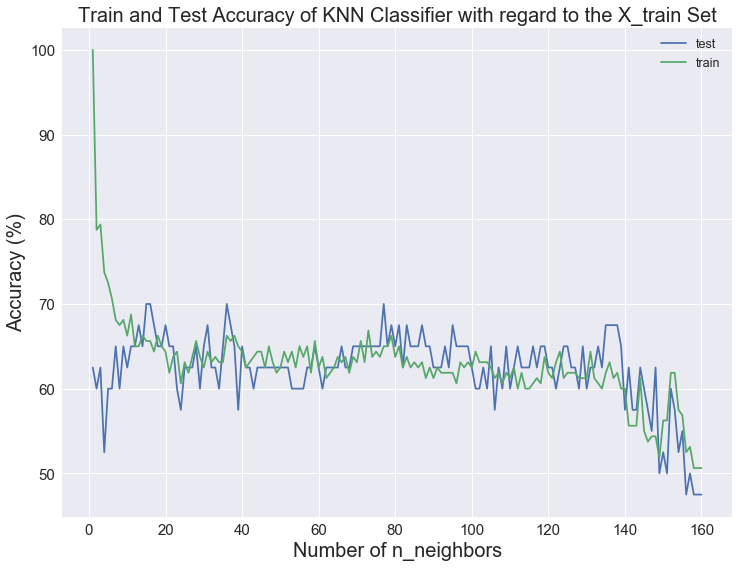

In [14]:
#calculates the train and test accuracy of KNN with K = [1,160]
ks = range(1,161)
accu_list=[]
train_list = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train) 
    y_pred=knn.predict(X_test)
    y_train_pred = knn.predict(X_train)
    accu_list.append(accuracy_score(y_test, y_pred) * 100 )
    train_list.append(accuracy_score(y_train, y_train_pred) * 100 )




#plot the accuracy of KNN classifier (according to this particular X_train Set)
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(ks, accu_list, label = "test")
ax.plot(ks, train_list, label = "train")

plt.title("Train and Test Accuracy of KNN Classifier with regard to the X_train Set", fontsize = 20)
plt.xlabel("Number of n_neighbors", fontsize = 20)
plt.ylabel("Accuracy (%)", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
ax.legend()

#<to help justificiation>: 
accu_series = pd.Series(accu_list, index = ks) 
knn_idx = accu_series.idxmax()
knn_val = accu_series.max()
print("the highest KNN test accuracy that can be obtained: {}%,".format(knn_val), end = " ")
print("and its first occurence is at n_neighbor: {}.".format(knn_idx))

print("the average test accuracy is : {0:0.2f}%".format(accu_series.mean() ))



#### 4.4 Decision Tree Classifier:
In this question, you will build a decision tree classifier by following same steps provided in the previous question. Only, you will be using "DecisionTreeClassifier" instead of "KNeighborsClassifier". You don't have to set any of the DT classifier parameters. This means you will use the default values for those parameters. **(2 Marks)** <br />
    
The output of this question should be in the following format: <br \>

    ***
    Q4.4: Default credit card user prediction using DT
    Train accuracy: # %
    Test accuracy: # %
    ***

Where # is the calculated classifier accuracy <span style="color:blue">rounded to 2 decimal places</span>.

Did you expect the decision tree classifier to perform better than K-NN, Yes/No? why? 

If the resulted accuracies does not follow your expectations, justify why this has happened. You might add extra code, visualisations and/or explanation to support your answer.


In [15]:
### answer Q4.4

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

#prints 
print("***")
print("Q4.4: Default credit card user prediction using DT")
#Train accuracy
y_pred_train = dt.predict(X_train)
print("Train accuracy: {0:0.2f} %".format( accuracy_score(y_train, y_pred_train) * 100 ) )

#Test accuracy
y_pred_test = dt.predict(X_test)
print("Test accuracy: {0:0.2f} %".format( accuracy_score(y_test, y_pred_test) * 100 ) )

print("***")

***
Q4.4: Default credit card user prediction using DT
Train accuracy: 100.00 %
Test accuracy: 52.50 %
***


the highest Decision Tree test accuracy that can be obtained: 60.0%, and its first occurence is at simulation no: 191.
the average test accuracy is : 54.15%


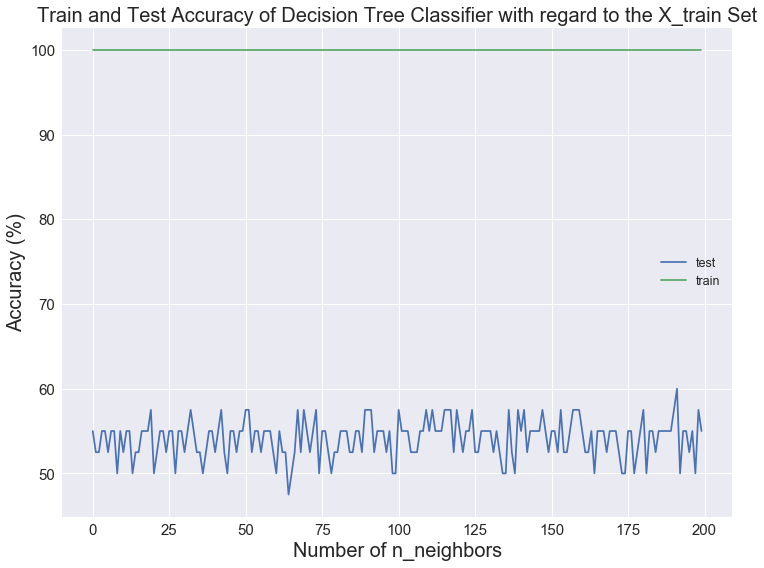

In [17]:
#calculates Train and Test accuracy for Decision Tree Classifier as much as 200 times. 
splits = range(0,200)
accu_list=[]
train_list = []
for split in splits:
    scaler = StandardScaler().fit(X_train)
    X_test=scaler.transform(X_test)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    y_train_pred = dt.predict(X_train)
    accu_list.append(accuracy_score(y_test, y_pred) * 100)
    train_list.append(accuracy_score(y_train, y_train_pred) * 100)
#Plot
accu_series = pd.Series(accu_list, index = splits)
dt_idx = accu_series.idxmax()
dt_val = accu_series.max() 
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(splits, accu_list, label = "test")
ax.plot(splits, train_list, label = "train")
ax.legend()



plt.title("Train and Test Accuracy of Decision Tree Classifier with regard to the X_train Set", fontsize = 20)
plt.xlabel("Number of n_neighbors", fontsize = 20)
plt.ylabel("Accuracy (%)", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)


print("the highest Decision Tree test accuracy that can be obtained: {}%,".format(dt_val), end = " ")
print("and its first occurence is at simulation no: {}.".format(dt_idx))

print("the average test accuracy is : {0:0.2f}%".format(accu_series.mean() ))



### Marking scheme

Correctness (24 marks): For each of the 4 questions a mark will be allocated for level of correctness (does it provide the right answer, is the logic right), according to the number in parentheses next to each question. Correctness will also take into account the readability and labelling provided for any plots and figures (plots should include title of the plot, labels/scale on axes, names of axes, and legends for colours where appropriate).

Coding style <span style="color:red">**(1 Mark)**</span>: Mark will be allocated for coding style. In particular the following aspects will be considered:

- Formatting of code (e.g. use of indentation and overall readability for a human)   
- Code modularity and flexibility. Use of functions or loops where appropriate, to avoid redundant or excessively verbose definitions of code.
- Use of python library functions (you should avoid reinventing logic if a library function can be used instead)
- Code commenting and clarity of logic. You should provide comments about the logic of our code for each question, so that it can be easily understood by the marker.

The final mark of the assignment will be scaled from 25 to 15 using the following formula:
$ your\_final\_mark = \frac{your\_mark\_out\_of\_25}{25} \times 15 $

### Submission Instructions
Via the LMS, submit a jupyter notebook containing the code. Make sure you get a submission receipt via email. If you didn't get a receipt via email, this means we didn't receive your submission and it will be considered as late submission.

### Other
Extensions and Late Submission Penalties: If requesting an extension due to illness, please submit a medical certificate to the lecturer. If there are any other exceptional circumstances, please contact the lecturer with plenty of notice. Late submissions without an approved extension will attract a penalty of 10% of the marks (i.e. 15) available per 24hr period (or part thereof)
that it is late. E.g. A late submission will be penalised 1.5 marks if 4 hours late, 3 marks if 28 hours late, 4.5 marks if 50 hours late, 6 marks if 73 hours late, 7.5 marks if 106 hours late, etc.

Phase 2 is expected to require 12-18 hours work.

### Academic Honesty

You are expected to follow the academic honesty guidelines on the University website
https://academichonesty.unimelb.edu.au

### Further Information

A project discussion forum has also been created on the subject LMS. Please use this in the first instance if you have questions, since it will allow discussion and responses to be seen by everyone. The Phase 1 project page will also contain a list of frequently asked questions.

### Acknowledgements
Dataset used in this assignment was sampled from the original dataset available at the UCI Machine Learning Repository. Further, few changes have been applied to some attributes. 


Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The original dataset can be found here at the UCI Machine Learning Repository.
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/home